-----
<div> <center> ESPACIO PARA BANNER DE LA MAESTRIA </center> </div>   

-----

<div style="text-align: justify">

# 04 - DBSCAN
por [Ignacio Sarmiento Barbieri](https://ignaciomsarmiento.github.io/) y [Lucas Gómez Tobón]()

El algoritmo DBSCAN (por su nombre en inglés *Density-based spatial clustering of applications with noise*) entiende los clústeres como áreas de alta densidad separadas por áreas de baja densidad. Debido a esto, los grupos encontrados por este método pueden tener cualquier forma, a diferencia de K-medias que supone grupos de forma convexa.

Para encontrar un clúster, DBSCAN comienza con un punto arbitrario $p$ y agrupa a todos los puntos alcanzables desde $p$ a partir de una estimación de nivel de densidad mínima simple. Esta densidad se basa en un umbral que se construye a partir de un radio $\epsilon$ (`eps`) desde $p$ para cual se espera un número mínimo de observaciones que caigan dentro de esa área (`MinPts` o `min_samples`). La intuición de este algoritmo es encontrar aquellas áreas que satisfagan esta densidad mínima y que estén separadas por áreas de menor densidad. Por razones de eficiencia, DBSCAN no realiza estimaciones de densidad entre puntos. En cambio, todos los vecinos dentro del radio $\epsilon$ de un punto central se consideran parte del mismo grupo que el punto central (llamado densidad directa alcanzable). Si alguno de estos vecinos es nuevamente un punto central, sus vecindarios se incluyen de manera transitiva (densidad alcanzable). Los puntos no centrales de este conjunto se denominan puntos fronterizos y todos los puntos dentro del mismo conjunto están conectados por densidad. Los puntos a los que no se puede llegar en densidad desde ningún punto central se consideran ruido y no pertenecen a ningún grupo.

Más formalmente, definimos los conceptos claves de esta metodología:

* **Eps-vecindario de un punto.** El barrio eps ($\epsilon$) de un punto $p$, denotado por $N_{eps}(P)$, se define como: 
$$ N_{eps}(P) = \{q\in D | dist(p, q) \leq \epsilon\}$$

* **Directamente alcanzable por densidad.** Un punto $p$ es directamente alcanzable por densidad desde un punto $q$ con respecto a un eps y MinPts dado si:
    1. $p \in N_{eps}(q)$
    2. $|N_{eps}(q)| \geq MinPts$
    
* **Alcanzable por densidad.** Un punto $p$ es alcanzable por densidad desde un punto $q$ con respecto a un eps y MinPts dado si hay una cadena de puntos $p_1$, $\cdots$, $p_n$, con $p_1 = q$ y $p_n = p$ tal que $p_{i + 1}$ es directamente alcanzable por densidad desde $p_1$. La densidad alcanzable es una extensión canónica por transitividad de la definición de directamente alcanzable por densidad. 

* **Conectado por densidad** Un punto $p$ está conectado por densidad con $q$ con respecto a un eps y MinPts dado si existe un punto $o$ tal que $p$ y $q$ son alcanzables por densidad desde $o$.

Intuitivamente, un cluster se define como un conjunto de puntos conectados por densidad que es máximo con respecto a la capacidad de alcance de la densidad. El ruido se definirá en relación con un conjunto determinado de clústeres. El ruido es simplemente el conjunto de puntos en $D$ que no pertenecen a ninguno de los clústeres.

* **Cluster.** Sea $D$ una base de datos de puntos. El clúster $C$ con respecto a Eps y MinPts es un subconjunto no vacío de $D$ que satisface las siguientes condiciones:
    1. $\forall\ p, q:$ if $p\in C$ y $q$ es alcanzable por densidad por $p$ con respecto al Eps y MinPts dados, entonces $q \in C$.
    2. $\forall\ p, q \in C:$ $p$ está conectado por densidad con $q$ con respecto al Eps y MinPts dados.
* **Ruido.** Sean $C_1, \cdots, C_k$ los clusteres conformados a partir de la base de datos $D$ usando los parámetros Eps y MinPts fijos. Definimos como ruido como todos los puntos que no pertenecen a ningún cluster pero están presentes en $D$:
$$noise = \{p\in D | \forall i: p \notin C_i \}$$

En ese orden de ideas, este algoritmo tiene principalmente dos parámetros con los que se define lo que es denso: `min_samples` y `eps`. `min_samples` hace referencia al número de observaciones en una vecindad para que un punto se considere como un punto central. Esto incluye el punto en sí. Y `eps` que significa la distancia máxima entre dos observaciones para que una se considere próxima a la otra. `min_samples` más altos o `eps` más bajos indican una densidad más alta necesaria para formar un grupo.

El parámetro `min_samples` controla principalmente qué tan tolerante es el algoritmo hacia el ruido. El parámetro `eps` es el más importante en este método porque controla la vecindad local de los puntos. Cuando se elige demasiado pequeño, la mayoría de los datos no se agruparán en absoluto y se etiquetarán como ruido. Cuando se elige demasiado grande, hace que los clústeres cercanos se fusionen en un clúster y, finalmente, todo el conjunto de datos se devuelva como un solo clúster. Para escoger estos valores la literatura recomienda crear una grilla de valores, probar todas las combinaciones posibles de la grilla y luego escoger la combinación de parámetros que maximicen algún criterio de calidad de la segmentación, como el Índice de Silhouette.

<center>

![DBSCAN](https://cdn-images-1.medium.com/max/640/1*tc8UF-h0nQqUfLC8-0uInQ.gif)

</center>

El algoritmo DBSCAN es determinista, siempre genera los mismos clústeres cuando se dan los mismos datos en el mismo orden. Sin embargo, los resultados pueden diferir cuando los datos se proporcionan en un orden diferente. 

A continuación se muestra como implementar este algoritmo en Python

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Creamos unos datos aleatorios
centros = [[1, 1], [-1, -1], [1, -1]]
X, verdaderos_clusteres = make_blobs(n_samples = 1000, centers = centros, cluster_std = 0.5, 
      random_state = 666)

# Estadísticas descriptivas de nuestros clusteres
pd.DataFrame(X).describe()

,0,1
count,1000.000000,1000.000000
mean,0.338967,-0.354529
std,1.060838,1.067710
min,-2.719355,-2.413510
25%,-0.655643,-1.185614
50%,0.682987,-0.675302
75%,1.167583,0.624814
max,2.608638,2.696758


<AxesSubplot:>

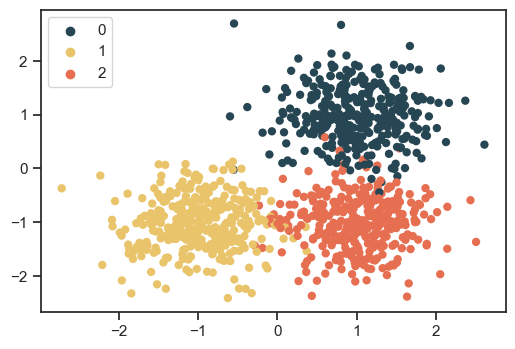

In [3]:
# Visualicemos nuestros datos
sns.set(rc = {"figure.dpi": 100, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")
colores = ["#264653", "#e9c46a", "#e76f51"]
sns.scatterplot(x = X[:,0], y = X[:,1], hue = verdaderos_clusteres, 
    palette = sns.color_palette(colores), linewidth = 0)

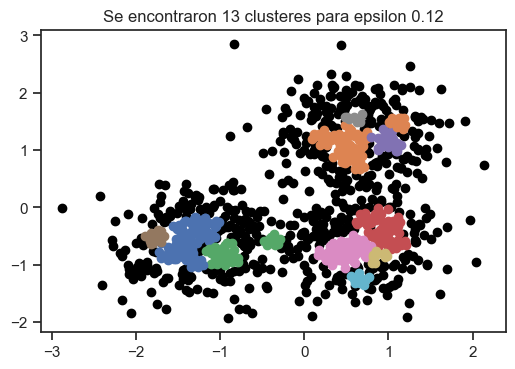

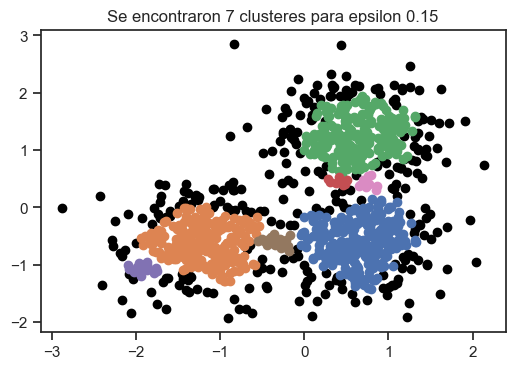

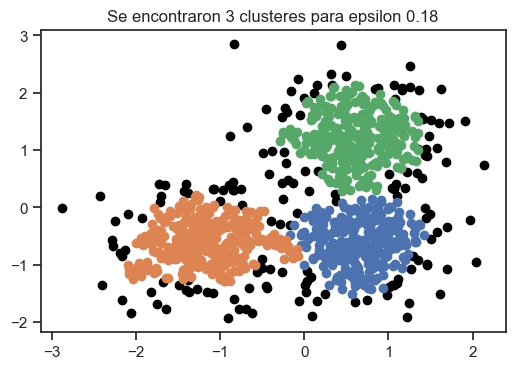

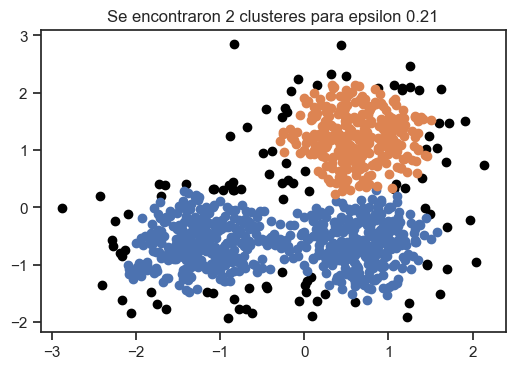

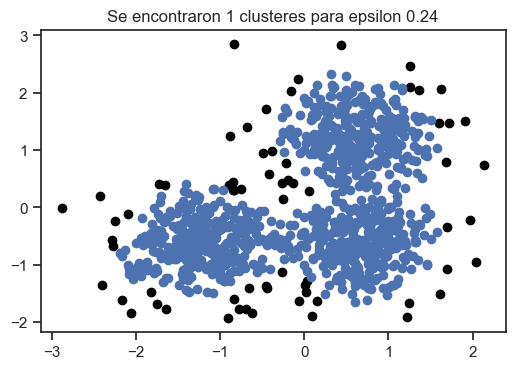

In [4]:
# Escalamos los datos
X = StandardScaler().fit_transform(X)

# Realizamos DBSCAN para diferentes valores de eps
for e in [0.12, 0.15, 0.18, 0.21, 0.24]:
    db = DBSCAN(eps = e, min_samples = 10).fit(X)
    clusteres = db.labels_
    n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
    resultado = pd.DataFrame(X).assign(Cluster = clusteres)
    plt.figure()
    for k in np.unique(clusteres):
        if k != -1:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0], 
                y = resultado.loc[resultado.Cluster == k, 1]
                )
        else:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0], 
                y = resultado.loc[resultado.Cluster == k, 1],
                c = "black"
                )
    plt.title('Se encontraron %d clusteres para epsilon %0.2f' % (n_clusteres, e))


Para tratar de encontrar eps de una manera más inteligente, vamos a fijar el valor de `min_samples` y luego vamos a usar el método propuesto por Rahmah y Sukaesih (2012) para encontrar el número óptimo de `eps`.

Los autores calculan la distancia a los `min_samples` más cercanos de cada punto y posteriormente ordenan los resultados de menor a mayor. Luego se grafican los resultados en donde el eje x corresponde al índice y el eje y la distancia. El valor óptimo de `eps` será el punto donde se encuentre la mayor curvatura en la gráfica. 

Intuitivamente, cuando los radios comienzan a aumentar de forma exponencial (el codo de la curva) significa que nos alejamos de la zona de alta densidad (valores normales) y entramos en la zona de baja densidad (valores atípicos).

Podemos calcular la distancia desde cada punto a su vecino más cercano usando `NeighborsNeighbors`. Este método devuelve dos matrices, una que contiene la distancia a los `n_neighbors` puntos más cercanos y la otra que contiene el índice para cada uno de esos puntos.

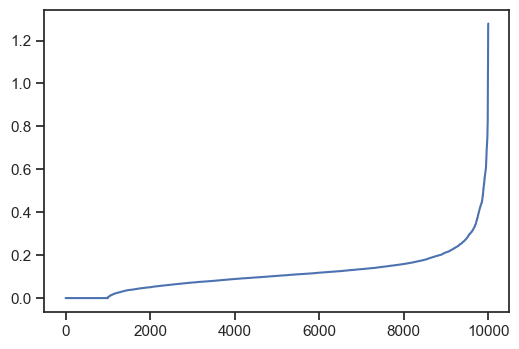

In [5]:
# Otra forma de encontrar el número óptimo de eps
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(X)
distancias, indices = nbrs.kneighbors(X)
distancias = np.sort(distancias.flatten())
plt.plot(distancias)

En la gráfica se puede ver que la parte exponencial de la curva comienza al rededor de una distancia de 0.18 - 0.20. Estos valores pueden ser definidos como `eps`.

Text(0.5, 1.0, 'Se encontraron 3 clusteres para epsilon 0.19')

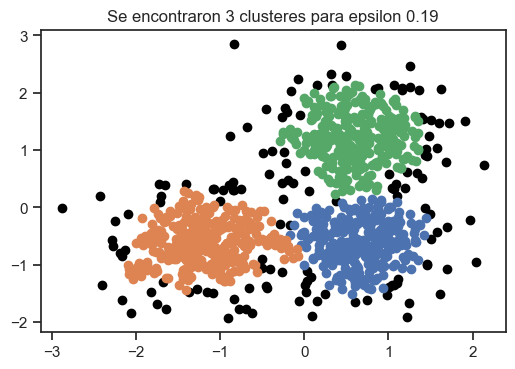

In [9]:
db = DBSCAN(eps = 0.19, min_samples = 10).fit(X)
clusteres = db.labels_
n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
resultado = pd.DataFrame(X).assign(Cluster = clusteres)
plt.figure()
for k in np.unique(clusteres):
    if k != -1:
        plt.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1]
            )
    else:
        plt.scatter(
            x = resultado.loc[resultado.Cluster == k, 0], 
            y = resultado.loc[resultado.Cluster == k, 1],
            c = "black"
            )
plt.title('Se encontraron %d clusteres para epsilon %0.2f' % (n_clusteres, 0.19))

Ahora comparemos DBSCAN, K-medias y Conglomerados jerarquicos

In [153]:
from sklearn import datasets

np.random.seed(666)
n_observaciones = 1500
# Creamos 6 bases de datos con mecanismos generadores de datos diferentes.
circulos = datasets.make_circles(n_samples = n_observaciones, factor = .5, noise = .05, random_state = 666)
lunas = datasets.make_moons(n_samples = n_observaciones, noise = .05, random_state = 666)
nubes = datasets.make_blobs(n_samples = n_observaciones, centers = 3, random_state = 170)
aleatorio = np.random.rand(n_observaciones, 2), None

transformacion = [[0.6, -0.6], [-0.4, 0.8]]
X_nubes2 = np.dot(nubes[0], transformacion)
nubes2 = (X_nubes2, nubes[1])

nubes3 = datasets.make_blobs(n_samples = n_observaciones, centers = 3, cluster_std = [1.0, 2.5, 0.5], random_state = 170)

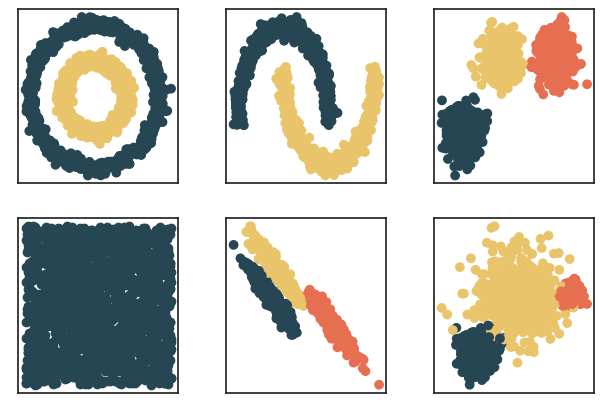

In [224]:
datos = [
    (circulos, {'n_clusteres': 2, 'eps': .3, "min_samples": 5}),
    (lunas, {'n_clusteres': 2, 'eps': .3, "min_samples": 5}),
    (nubes, {'n_clusteres': 3, 'eps': .2, "min_samples": 5}), 
    (aleatorio, {'n_clusteres': 3, 'eps': .3, "min_samples": 5}), 
    (nubes2, {'n_clusteres': 3, 'eps': .184, "min_samples": 5}), 
    (nubes3, {'n_clusteres': 3, 'eps': .18, "min_samples": 5})
    ]

fig, axs = plt.subplots(2, 3)
plt.subplots_adjust(left = .02, right = .98, bottom = .001, top = .96, wspace = .3, hspace = .2)
 
axs = axs.ravel()
n = 0
diccionario = {0: colores[0], 1: colores[1], 2: colores[2], "vacio": colores[0]}
for df, parametros in datos:
    clusteres = df[1]
    if clusteres is None:
        clusteres = ["vacio"]
    axs[n].scatter(x = df[0][:,0], y = df[0][:,1], c = [diccionario[k] for k in clusteres])
    axs[n].set_xticks([])
    axs[n].set_yticks([])
    n += 1

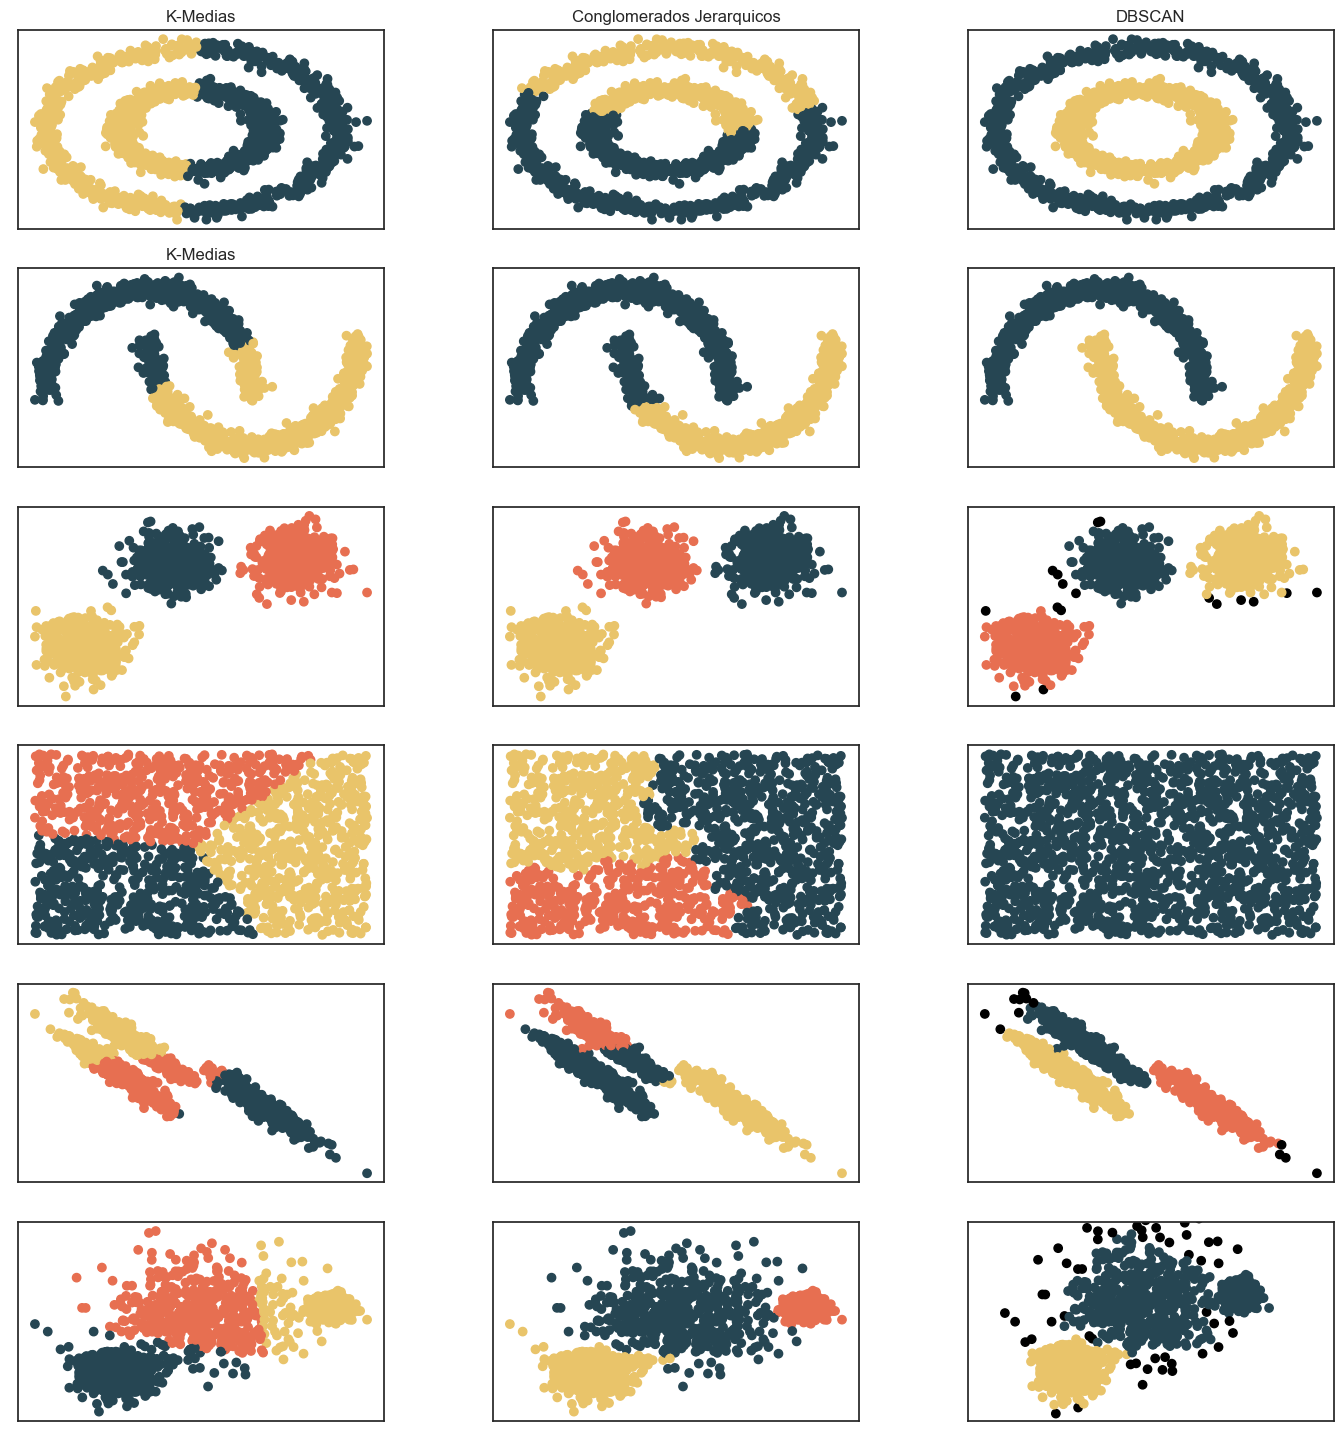

In [225]:
n = 0
fig, axs = plt.subplots(6, 3, figsize = (9 * 1.3 + 2, 14.5))
axs = axs.flatten()
plt.subplots_adjust(left = .02, right = .98, bottom = .001, top = .96, wspace = .3, hspace = .2)
colores = ["#264653", "#e9c46a", "#e76f51", "#2a9d8f", "#f4a261", "#d00000"]
diccionario = {-1: "black", 0: colores[0], 1: colores[1], 2: colores[2], 
    3: colores[3], 4: colores[4], 5: colores[5]}

for df, parametros in datos:
    X, y = df

    # Normalizamos la base de datos para que todas nos queden en la misma escala
    X = StandardScaler().fit_transform(X)
    kmedias = KMeans(n_clusters = parametros['n_clusteres'], random_state = 666).fit(X)
    aglomerativo = AgglomerativeClustering(n_clusters = parametros['n_clusteres'], linkage = 'ward')
    dbscan = DBSCAN(eps = parametros['eps'], min_samples = parametros["min_samples"])

    metodologia = (
            ('K-Medias', kmedias),
            ('Conglomerados Jerarquicos', aglomerativo),
            ('DBSCAN', dbscan)
        )

    for nombre, enlace in metodologia:
        enlace.fit(X)
        y_pred = enlace.labels_.astype(int)
        if n in range(0, 4):
            axs[n].title.set_text(nombre)
        color = [diccionario[k] for k in y_pred]
        axs[n].scatter(X[:, 0], X[:, 1], c = color)
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        axs[n].set_xticks([])
        axs[n].set_yticks([])
        n += 1
        
plt.show()

# Referencias
Ester, M., H. P. Kriegel, J. Sander, and X. Xu. (1996). A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise. In Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226–231. 

Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. In ACM Transactions on Database Systems (TODS), 42(3), 19.

Rahmah, N., & Sitanggang, I. S. (2016). Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra. In IOP Conference Series: Earth and Environmental Science (Vol. 31, p. 012012). IOP Publishing. https://doi.org/10.1088/1755-1315/31/1/012012